In [141]:
# Import libraries.
%pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from keras import layers
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [142]:

# load and visualize the data
dataset = pd.read_csv('insurance.csv')
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [143]:
# split data for training and testing
y = dataset.expenses
data_features = ['age', 'sex', 'bmi', 'children', 'smoker']
X = dataset[data_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 0)

In [144]:
# check for missing values
cols_missing = [col for col in train_X.columns if train_X[col].isnull().any()]
print(cols_missing)

[]


In [145]:
# check for categorical values
categ = (train_X.dtypes == 'object')
categ_cols = list(categ[categ].index)
print("Columns with categorical values are:")
print(categ_cols)
print(val_X)

Columns with categorical values are:
['sex', 'smoker']
      age     sex   bmi  children smoker
578    52    male  30.2         1     no
610    47  female  29.4         1     no
569    48    male  40.6         2    yes
1034   61    male  38.4         0     no
198    51  female  18.1         0     no
...   ...     ...   ...       ...    ...
1084   62  female  30.5         2     no
726    41    male  28.4         1     no
1132   57    male  40.3         0     no
725    30  female  39.1         3    yes
963    46    male  24.8         3     no

[268 rows x 5 columns]


In [146]:
# process categorical values
from sklearn.preprocessing import OneHotEncoder

my_encoder = OneHotEncoder(handle_unknown='ignore', sparse = False)

OH_cols_train = pd.DataFrame(my_encoder.fit_transform(train_X[categ_cols]))
OH_cols_val = pd.DataFrame(my_encoder.transform(val_X[categ_cols]))

OH_cols_train.index = train_X.index
OH_cols_val.index = val_X.index

num_train_X = train_X.drop(categ_cols, axis = 1)
num_val_X = val_X.drop(categ_cols, axis = 1)


OH_train_X = pd.concat([num_train_X, OH_cols_train], axis = 1)
OH_val_X = pd.concat([num_val_X, OH_cols_val], axis = 1)

OH_train_X.columns = OH_train_X.columns.astype(str)
OH_val_X.columns = OH_val_X.columns.astype(str)

OH_train_X.rename(columns = {'2' : 'no smoking'}, inplace = True)
OH_val_X.rename(columns = {'2' : 'no smoking'}, inplace = True)
OH_train_X.rename(columns = {'3' : 'yes smoking'}, inplace = True)
OH_val_X.rename(columns = {'3' : 'yes smoking'}, inplace = True)

OH_train_X.rename(columns = {'1' : 'male'}, inplace = True)
OH_val_X.rename(columns = {'1' : 'male'}, inplace = True)
OH_train_X.rename(columns = {'0' : 'female'}, inplace = True)
OH_val_X.rename(columns = {'0' : 'female'}, inplace = True)


print(OH_val_X)




      age   bmi  children  female  male  no smoking  yes smoking
578    52  30.2         1     0.0   1.0         1.0          0.0
610    47  29.4         1     1.0   0.0         1.0          0.0
569    48  40.6         2     0.0   1.0         0.0          1.0
1034   61  38.4         0     0.0   1.0         1.0          0.0
198    51  18.1         0     1.0   0.0         1.0          0.0
...   ...   ...       ...     ...   ...         ...          ...
1084   62  30.5         2     1.0   0.0         1.0          0.0
726    41  28.4         1     0.0   1.0         1.0          0.0
1132   57  40.3         0     0.0   1.0         1.0          0.0
725    30  39.1         3     1.0   0.0         0.0          1.0
963    46  24.8         3     0.0   1.0         1.0          0.0

[268 rows x 7 columns]


c:\Users\michels\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [147]:
for data in OH_train_X.select_dtypes("object"):
    OH_train_X[data], _ = OH_train_X[data].factorize()

# for data in OH_train_X.select_dtypes("float64"):
#     OH_train_X[data], _ = OH_train_X[data].factorize

print(OH_train_X)
discrete_features = (OH_train_X.dtypes == int) | (OH_train_X.dtypes == 'int64')
print(discrete_features)

      age   bmi  children  female  male  no smoking  yes smoking
621    37  34.1         4     0.0   1.0         0.0          1.0
194    18  34.4         0     0.0   1.0         1.0          0.0
240    23  36.7         2     1.0   0.0         0.0          1.0
1168   32  35.2         2     0.0   1.0         1.0          0.0
1192   58  32.4         1     1.0   0.0         1.0          0.0
...   ...   ...       ...     ...   ...         ...          ...
763    27  26.0         0     0.0   1.0         1.0          0.0
835    42  36.0         2     0.0   1.0         1.0          0.0
1216   40  25.1         0     0.0   1.0         1.0          0.0
559    19  35.5         0     0.0   1.0         1.0          0.0
684    33  18.5         1     1.0   0.0         1.0          0.0

[1070 rows x 7 columns]
age             True
bmi            False
children        True
female         False
male           False
no smoking     False
yes smoking    False
dtype: bool


age            1.372181
no smoking     0.367263
yes smoking    0.367263
children       0.141411
female         0.116587
male           0.116587
bmi            0.095194
Name: MI Scores, dtype: float64


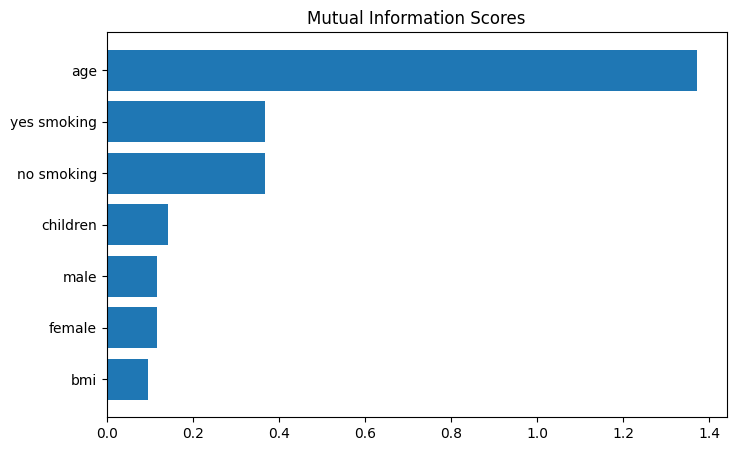

In [148]:
# Mutual Information check
from sklearn.feature_selection import mutual_info_regression
def make_mi_score(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name = 'MI Scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_score(OH_train_X, train_y, discrete_features)
print(mi_scores)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")



plt.figure(dpi = 100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [149]:
my_model= GradientBoostingRegressor()
my_model.fit(OH_train_X, train_y)
predict = my_model.predict(OH_val_X)
score = mean_absolute_error(val_y, predict)
print(score)



2372.2506798047443
